## Using Different Base Learners in XGBoost

XGBoost is a powerful gradient boosting framework that builds an ensemble of weak learners to create a strong predictive model.
By default, XGBoost uses **decision trees** as its base learners, but it can also integrate **other types of learners**.

### What is a Base Learner?
A base learner (or weak learner) is the fundamental model used to make predictions in each boosting round.
Each learner focuses on reducing the residual errors from the previous round.

### Common Base Learners in XGBoost

#### 1. **Decision Tree (Default)**
- Works by creating a series of decision rules.
- Each new tree corrects the errors of the previous trees.
- Controlled by parameters like `max_depth`, `min_child_weight`, and `gamma`.

#### 2. **Linear Models (Logistic/Linear Regression)**
- Uses a linear function instead of a tree structure.
- For regression tasks, it behaves like linear regression.
- For classification, it can use logistic regression.
- Set with `booster='gblinear'`.

### How XGBoost Uses Base Learners
- Each base learner is trained sequentially using **gradient boosting**.
- It minimizes a loss function (e.g., log loss for classification, mean squared error for regression).
- The final prediction is a combination (weighted sum) of all learners.

### Key Parameters
- **`booster`**
  - Specifies the type of base learner.
  - Options: `'gbtree'` (default), `'gblinear'`, `'dart'` (dropout trees).

- **`learning_rate`**
  - Controls the contribution of each learner.

- **`n_estimators`**
  - Number of boosting rounds (number of base learners to train).


In [10]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
import os
import pandas as pd

base_dir = "datasets"
file_name = "ames_housing_trimmed_processed.csv"
housing = pd.read_csv(os.path.join(base_dir, file_name))

housing.head()

,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,Remodeled,GrLivArea,BsmtFullBath,BsmtHalfBath,...,HouseStyle_1.5Unf,HouseStyle_1Story,HouseStyle_2.5Fin,HouseStyle_2.5Unf,HouseStyle_2Story,HouseStyle_SFoyer,HouseStyle_SLvl,PavedDrive_P,PavedDrive_Y,SalePrice
0,60,65.0,8450,7,5,2003,0,1710,1,0,...,0,0,0,0,1,0,0,0,1,208500
1,20,80.0,9600,6,8,1976,0,1262,0,1,...,0,1,0,0,0,0,0,0,1,181500
2,60,68.0,11250,7,5,2001,1,1786,1,0,...,0,0,0,0,1,0,0,0,1,223500
3,70,60.0,9550,7,5,1915,1,1717,1,0,...,0,0,0,0,1,0,0,0,1,140000
4,60,84.0,14260,8,5,2000,0,2198,1,0,...,0,0,0,0,1,0,0,0,1,250000


In [3]:
X, y = housing.iloc[:,:-1], housing.iloc[:,-1]

### Decision Trees As Base Learners

Train an XGBoost model to predict house prices using the provided dataset.
The features (`X`) contain information about the houses and their locations, while the target (`y`) represents the house prices.

By default, XGBoost uses decision trees as base learners, so no additional specification is needed for this.
Instantiate the XGBoost regressor with the desired parameters.
Fit the model on the training data to learn the relationship between the features and the target.
Use the trained model to make predictions on the test data and evaluate its performance using an appropriate metric such as RMSE.


In [4]:
#1. Split df into training and testing sets, holding out 20% for testing. Use a random_state of 123.
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state = 123)

#2. Instantiate the XGBRegressor as xg_reg, using a seed of 123. Specify an objective of "reg:squarederror" and use 10 trees. Note: You don't have to specify booster="gbtree" as this is the default.
import xgboost as xgb
xg_reg = xgb.XGBRegressor(objective = "reg:squarederror", n_estimators =10, seed = 123)

#3. Fit xg_reg to the training data and predict the labels of the test set. Save the predictions in a variable called preds.
xg_reg.fit(X_train, y_train)
preds = xg_reg.predict(X_test)

#4. Compute the rmse using np.sqrt() and the mean_squared_error().
from sklearn.metrics import mean_squared_error
RMSE = np.sqrt(mean_squared_error(y_test, preds))
print("RMSE: %f" % (RMSE))




RMSE: 31292.976337


## Linear Base Learners

Train an XGBoost model to predict house prices using a linear learner instead of trees.
XGBoost supports linear base learners through the `gblinear` booster option, which creates a regularized linear regression model.

To use this, define a parameter dictionary that specifies `"booster": "gblinear"`.
Convert the training and testing datasets into `DMatrix` objects, which are optimized data structures required by XGBoost’s training API.
Train the model using `xgb.train()` with the defined parameters and the training `DMatrix`.
Use the trained model’s `.predict()` method on the test `DMatrix` to generate predictions.
Evaluate the predictions using an appropriate metric such as RMSE to measure model performance.


In [5]:
#1. Create two DMatrix objects - DM_train for the training set (X_train and y_train), and DM_test (X_test and y_test) for the test set.
DM_train = xgb.DMatrix(data=X_train, label = y_train)
DM_test = xgb.DMatrix(data=X_test, label = y_test)


#2. Create a parameter dictionary that defines the "booster" type you will use ("gblinear") as well as the "objective" you will minimize ("reg:squarederror").
params = {'objective':'reg:squarederror',
          'booster':"gblinear"}

#3. Train the model using xgb.train(). You have to specify arguments for the following parameters: params, dtrain, and num_boost_round.
xg = xgb.train(params=params, dtrain=DM_train, num_boost_round = 5)

#4. Predict the labels on the test set using xg_reg.predict(), passing it DM_test. Assign to preds.
xg_preds = xg.predict(DM_test)

# Compute and print the RMSE
rmse = np.sqrt(mean_squared_error(y_test,preds))
print("RMSE: %f" % (rmse))

RMSE: 31292.976337


## Evaluating XGBoost Model Quality with Cross-Validation.

Use cross-validation to measure model quality on the Ames housing dataset.
The evaluation will focus on two metrics: **Root Mean Squared Error (RMSE)** and **Mean Absolute Error (MAE)**.

Steps:

* Define parameters for the XGBoost model, starting with `"objective": "reg:squarederror"` and specifying the evaluation metric (`"rmse"` or `"mae"`).
* Convert the features and target into a `DMatrix` for optimized computation.
* Perform 4-fold cross-validation with 5 boosting rounds using `xgb.cv()`.
* For RMSE: extract the RMSE values from the output and print the result from the final boosting round.
* Repeat the process for MAE by updating the metric in the parameters to `"mae"` and printing the final boosting round MAE.

This allows you to compare how different evaluation metrics represent model performance on the same dataset.


In [6]:
#1. Perform 4-fold cross-validation with 5 boosting rounds and "rmse" as the metric.

#RMSE
housing_dmatrix = xgb.DMatrix(data=X, label=y)

# Create the parameter dictionary: params
params1 = {'objective':'reg:squarederror', 'max_depth':4}

#Performing cross validation.
cv_results1 = xgb.cv(dtrain=housing_dmatrix, params=params1, nfold=4, num_boost_round = 5, metrics='rmse', as_pandas=True, seed=123)

print(cv_results1)
print((cv_results1['test-rmse-mean']).tail(1))



   train-rmse-mean  train-rmse-std  test-rmse-mean  test-rmse-std
0     61729.274347      679.377718    63760.373921    2933.496745
1     49654.722560      757.696043    53641.473273    3504.687699
2     41325.179705      702.570217    46796.539109    3500.230673
3     35351.338939      772.520024    41986.507917    4018.899377
4     31020.037762      574.099506    39337.103754    4583.588151
4    39337.103754
Name: test-rmse-mean, dtype: float64


In [7]:
#1. Perform 4-fold cross-validation with 5 boosting rounds and "rmse" as the metric.

#MAE
housing_dmatrix = xgb.DMatrix(data=X, label=y)

# Create the parameter dictionary: params
params1 = {'objective':'reg:squarederror', 'max_depth':4}

#Performing cross validation.
cv_results1 = xgb.cv(dtrain=housing_dmatrix, params=params1, nfold=4, num_boost_round = 5, metrics='mae', as_pandas=True, seed=123)

print(cv_results1)
print((cv_results1['test-mae-mean']).tail(1))



   train-mae-mean  train-mae-std  test-mae-mean  test-mae-std
0    43978.370783     265.516103   44551.030843    875.854839
1    34677.517623     229.638967   35869.958037   1015.100363
2    28338.053913     290.958119   30144.292723    902.020896
3    24076.657948     451.048602   26492.798309    835.506913
4    21115.815254     428.025143   24289.425664    994.137976
4    24289.425664
Name: test-mae-mean, dtype: float64


## Applying L2 Regularization in XGBoost

Introduce L2 regularization (ridge penalty) into the XGBoost model and observe its impact on predictive performance.
In XGBoost, the L2 regularization parameter is controlled using `"lambda"`.

Steps:

* Set up the parameter dictionary with `"objective": "reg:squarederror"` and include the `"lambda"` key to apply L2 regularization.
* Convert the features and target into a `DMatrix`.
* Perform cross-validation using `xgb.cv()` with a chosen number of folds and boosting rounds.
* Adjust the value of `"lambda"` across different runs (e.g., 0, 1, 10) to see how increasing the penalty affects the evaluation metric.

This experiment helps identify the role of L2 regularization in controlling model complexity and improving generalization.


In [8]:
#2. Create an initial parameter dictionary specifying an "objective" of "reg:squarederror" and "max_depth" of 3.
reg_params = [1, 10, 100]
params2= {'objective':'reg:squarederror','max_depth':3}

#3. Use xgb.cv() inside of a for loop and systematically vary the "lambda" value by passing in the current l2 value (reg).
rmses_l2 = []

# Iterate over reg_params
for reg in reg_params:

    # Update l2 strength
    params["lambda"] = reg

    # Pass this updated param dictionary into cv
    cv_results_rmse = xgb.cv(dtrain=housing_dmatrix, params=params2, nfold=2, num_boost_round=5, metrics="rmse", as_pandas=True, seed=123)

    # Append best rmse (final round) to rmses_l2
    rmses_l2.append(cv_results_rmse["test-rmse-mean"].tail(1).values[0])

# Look at best rmse per l2 param
print("Best rmse as a function of l2:")
print(pd.DataFrame(list(zip(reg_params, rmses_l2)), columns=["l2", "rmse"]))

Best rmse as a function of l2:
    l2          rmse
0    1  40871.470438
1   10  40871.470438
2  100  40871.470438


## Visualizing Trees in an XGBoost Model

After training an XGBoost model, you can visualize the individual decision trees that make up the ensemble. XGBoost provides the `plot_tree()` function for this purpose.

Steps:

* Train the XGBoost model on the full dataset using the learning API.
* Call `plot_tree(model, num_trees=k)` where `k` specifies which tree to display.
* Experiment with different values of `num_trees` (e.g., 0, 1, 2) to explore how the trees evolve across boosting rounds.

Tree visualization helps you understand how features are split, how decision paths are formed, and how the ensemble builds complexity over multiple boosting iterations.


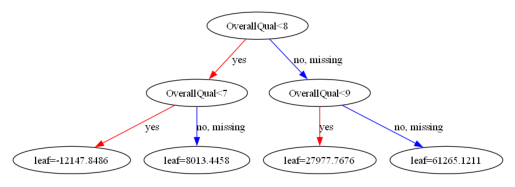

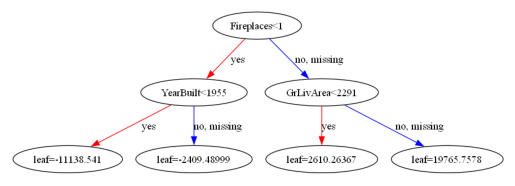

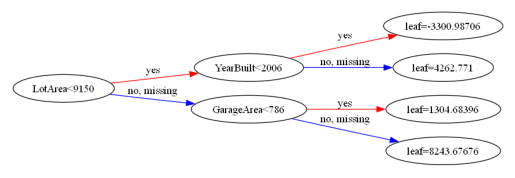

In [11]:
#1. Create a parameter dictionary with an "objective" of "reg:squarederror" and a "max_depth" of 2.
paramsV = {'objective':"reg:squarederror", 'max_depth':2}

#2. Train the model using 10 boosting rounds and the parameter dictionary you created. Save the result in xg_viz.
xg_viz = xgb.train(params=paramsV, dtrain=housing_dmatrix, num_boost_round=10)

#3. Plot the first tree using xgb.plot_tree(). It takes in two arguments - the model (in this case, xg_viz), and num_trees, which is 0-indexed. So to plot the first tree, specify num_trees=0.
xgb.plot_tree(xg_viz, tree_idx=0)
plt.show()


xgb.plot_tree(xg_viz, tree_idx=4)
plt.show()


xgb.plot_tree(xg_viz, tree_idx=9, rankdir='LR')
plt.show()

## Visualizing Feature Importances in XGBoost

Beyond tree visualization, you can analyze how important each feature is in your trained XGBoost model. This is done by checking how often each feature is used for splits across all trees in the ensemble.

Steps:

* Train the XGBoost model on your dataset.
* Use the `plot_importance()` function and pass the trained model.
* A bar chart will be generated, ranking features by their frequency of use in splits.

This visualization highlights which features the model relies on most for predictions, giving insight into their relative importance in shaping decision boundaries.


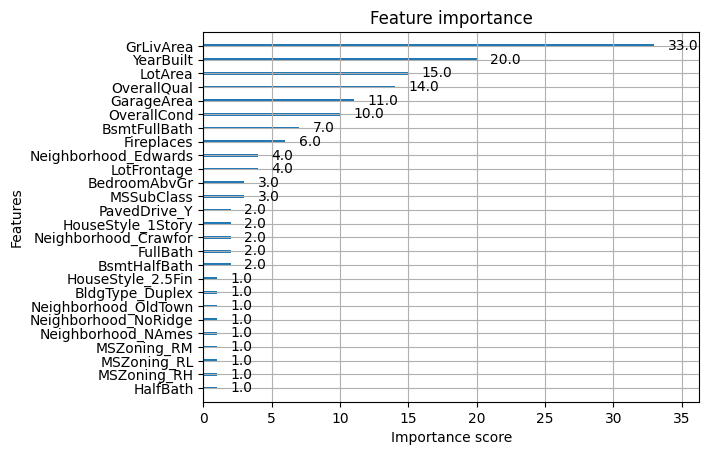

In [12]:
#2. Create a parameter dictionary with appropriate "objective" ("reg:squarederror") and a "max_depth" of 4.
paramsViz = {'objective':"reg:squarederror", 'max_depth':4}

#3. Train the model with 10 boosting rounds, exactly as you did in the previous exercise.
xg_viz0 = xgb.train(params=paramsViz, dtrain=housing_dmatrix, num_boost_round=10)

#4. Use xgb.plot_importance() and pass in the trained model to generate the graph of feature importances.
xgb.plot_importance(xg_viz0)
plt.show()